# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

---
## Load The Data

In [2]:
# Load pickled data
import pickle

# Set Directories

training_file = "./data/train.p"
validation_file= "./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Dataset Summary

In [45]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Image Shape
image_shape = X_train[0].shape

# Number of Classes
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Dataset Visualization

Following is a random sample of the dataset with its label

10


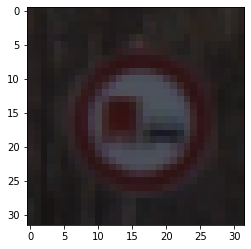

In [4]:
import matplotlib.pyplot as plt
import random

%matplotlib inline

index = random.randint(0, len(X_train))

plt.imshow(X_train[index])
print(y_train[index])

### Data Distribution

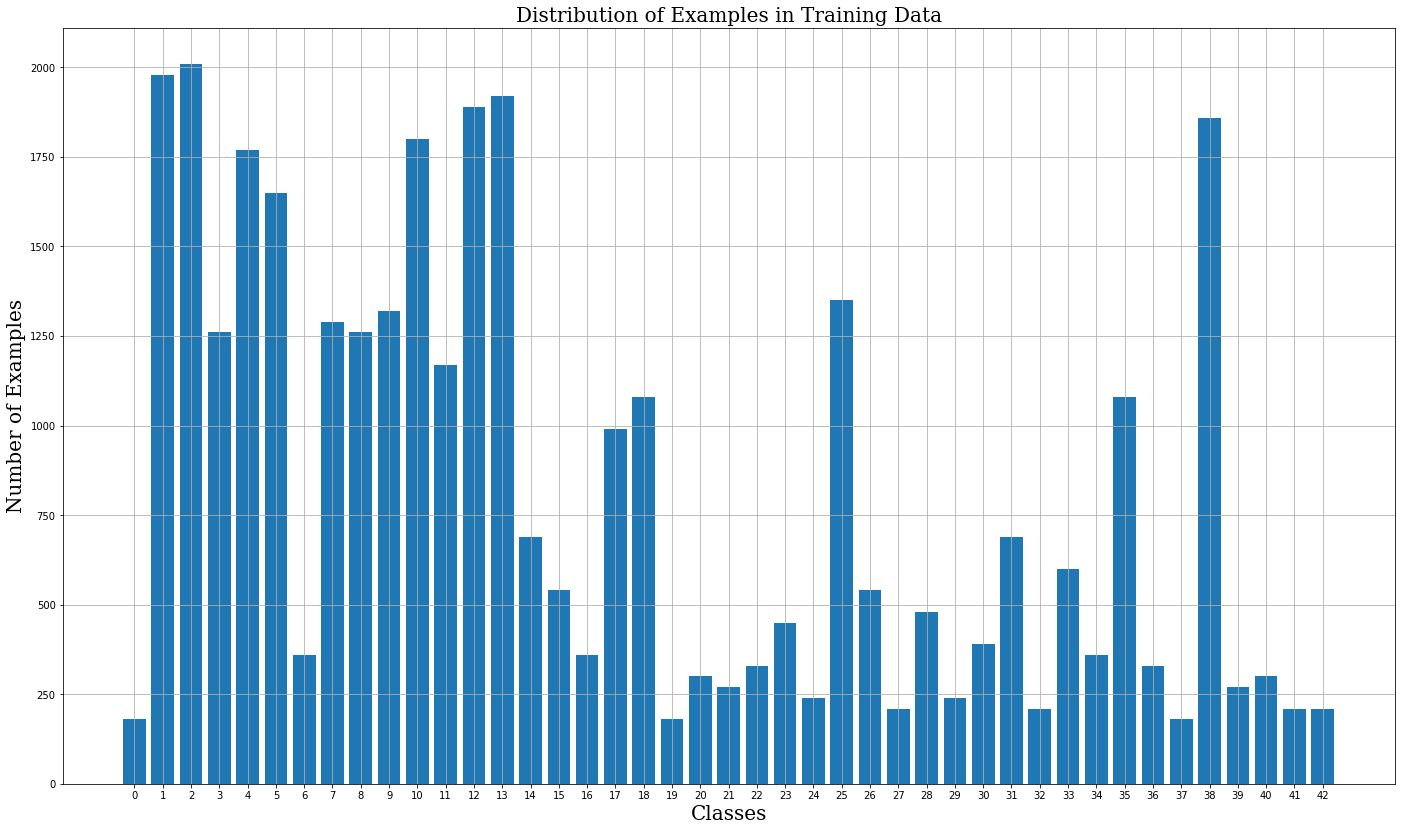

In [44]:
num_ex = []
classes = np.arange(n_classes)

for i in range(n_classes):
    num_ex.append(len(np.where(y_train == i)[0]))

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_axes([0,0,1,1])
ax.bar(classes,num_ex)
plt.xticks(classes)
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
plt.xlabel("Classes", font)
plt.ylabel("Number of Examples", font)
plt.title("Distribution of Examples in Training Data", font)
plt.grid(True)

As we can observe, the training data is very skewed and some classes have significantly less number of training examples than others.

----

## CovNet Model Architecture


### Data Preprocessing

All images have been converted to grayscale for helping the network learn faster. The data has also been mean normalized and scaled from 0 to 1 for improving the optimizer performance.

In [ ]:
# Grayscale training and validation sets

train_grays = np.mean(X_train, axis = -1)
valid_grays = np.mean(X_valid, axis = -1)

# Reshape grayscaled images into appropriate size for inputting into the CovNet

train_grays = np.reshape(train_grays, [n_train, train_grays[0].shape[0], train_grays[0].shape[1], 1])
valid_grays = np.reshape(valid_grays, [n_valid, train_grays[0].shape[0], train_grays[0].shape[1], 1])

# Mean normalize and scale validation and test sets

X_train = np.divide(np.subtract(train_grays, np.mean(train_grays)), np.mean(train_grays))
X_valid = np.divide(np.subtract(valid_grays, np.mean(valid_grays)), np.mean(valid_grays))

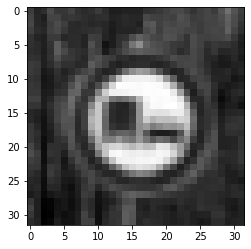

In [49]:
plt.imshow(X_train[index, :, :, 0], cmap='gray')

In [5]:
# Shuffle the dataset
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

### Hyperparameters

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

EPOCHS = 10
BATCH_SIZE = 128
rate = 0.001

Instructions for updating:
non-resource variables are not supported in the long term


### Modified LeNet-5 Architecture

Modifications:
1. Removed all max pooling layers and replaced with dropouts to prevent overfitting without loss of data.
2. Added additional convolution layer to reduce input image size and increase depth. This was necessary as there is no max pooling layer in the network.
3. Added additional fully connected layer.

In [7]:
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ## weight = tf.Variable(tf.truncated_normal([filter_height, filter_width, color_channels, k_output]))
    ## bias = tf.Variable(tf.zeros(k_output))
    
    # Convolutional Layer 1. Input = 32x32x1. Output = 28x28x12.
    
    wc1 = tf.Variable(tf.truncated_normal([5, 5, 1, 12], mu, sigma))
    bc1 = tf.Variable(tf.zeros(12))
    conv1 = tf.nn.conv2d(x, wc1, strides=[1, 1, 1, 1], padding = 'VALID')
    conv1 = tf.nn.bias_add(conv1, bc1)

    # Layer 1 Activation and Dropout
    
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # Convolutional Layer 2. Input = 28x28x12. Output = 20x20x32.
    
    wc2 = tf.Variable(tf.truncated_normal([9, 9, 12, 32], mu, sigma))
    bc2 = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(conv1, wc2, strides=[1, 1, 1, 1], padding = 'VALID')
    conv2 = tf.nn.bias_add(conv2, bc2)
    
    # Layer 2 Activation and Dropout
    
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Convolutional Layer 3. Input = 20x20x32. Output = 10x10x64.
    
    wc3 = tf.Variable(tf.truncated_normal([11, 11, 32, 64], mu, sigma))
    bc3 = tf.Variable(tf.zeros(64))
    conv3 = tf.nn.conv2d(conv2, wc3, strides=[1, 1, 1, 1], padding = 'VALID')
    conv3 = tf.nn.bias_add(conv3, bc3)
    
    # Layer 3 Activation and Dropout
    
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.dropout(conv3, keep_prob)
    
    # Flatten. Input = 10x10x64. Output = 6400.
    
    fc1 = tf.layers.flatten(conv3)
    
    # Layer 3: Fully Connected. Input = 6400. Output = 1600.
    
    wd1 = tf.Variable(tf.truncated_normal((6400, 1600), mu, sigma))
    bd1 = tf.Variable(tf.zeros(1600))
    fc1 = tf.add(tf.matmul(fc1, wd1), bd1)  
    
    # Layer 3 Activation and Dropout
    
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 1600. Output = 400.
    
    wd2 = tf.Variable(tf.truncated_normal((1600, 400), mu, sigma))
    bd2 = tf.Variable(tf.zeros(400))
    fc2 = tf.add(tf.matmul(fc1, wd2), bd2)
    
    # Layer 4 Activation and Dropout
    
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 400. Output = 100.
    
    wd3 = tf.Variable(tf.truncated_normal((400, 100), mu, sigma))
    bd3 = tf.Variable(tf.zeros(100))
    fc3 = tf.add(tf.matmul(fc2, wd3), bd3)
    
    # Layer 5 Activation and Dropout
    
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, keep_prob)
    
    # Layer 6: Fully Connected. Input = 100. Output = 43.
    
    wd4 = tf.Variable(tf.truncated_normal((100, 43), mu, sigma))
    bd4 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc3, wd4), bd4)
    
    return logits

### Set up Tensorflow Parameters

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

### Definitions: Optimizer, Loss Function and Training Operation

In [9]:
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Accuracy Operation

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Model Training, Validation and Test Accuracy

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})

        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
      
    # Run model on test set, once finalized. Uncomment following code to test.
    test_grays = np.mean(X_test, axis = -1)
    test_grays = np.reshape(test_grays, [n_test, test_grays[0].shape[0], test_grays[0].shape[1], 1])
    X_test = np.divide(np.subtract(test_grays, np.mean(test_grays)), np.mean(test_grays))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy)) 
    
    # Save Model
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.266
Training Accuracy = 0.314

EPOCH 2 ...
Validation Accuracy = 0.800
Training Accuracy = 0.840

EPOCH 3 ...
Validation Accuracy = 0.910
Training Accuracy = 0.945

EPOCH 4 ...
Validation Accuracy = 0.938
Training Accuracy = 0.971

EPOCH 5 ...
Validation Accuracy = 0.954
Training Accuracy = 0.982

EPOCH 6 ...
Validation Accuracy = 0.961
Training Accuracy = 0.986

EPOCH 7 ...
Validation Accuracy = 0.968
Training Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.967
Training Accuracy = 0.993

EPOCH 9 ...
Validation Accuracy = 0.968
Training Accuracy = 0.994

EPOCH 10 ...
Validation Accuracy = 0.968
Training Accuracy = 0.995

Test Accuracy = 0.942
Model saved


---

## Model Testing on New Images

6 images of German Traffic Signs were downloaded from Google Images and were labelled manually. The following code runs the network on these images and the classification predictions have been documented.

### Load and Output the Images

30


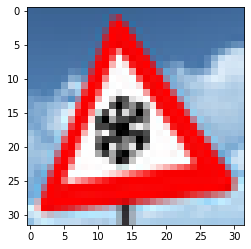

In [55]:
import glob
from PIL import Image

# Extract images 
filelist = glob.glob('images/*.png')

new_images = []
img_size = [32, 32, 3]
for file in filelist:
    image = Image.open(file)
    image = image.resize((32,32), Image.ANTIALIAS)
    new_image = np.array(image.getdata(), np.uint8).reshape(img_size[0], img_size[1], img_size[2])
    new_images.append(new_image)

# Label images based on 'signnames.csv'
y_new = np.array([38, 25, 17, 18, 28, 30], np.uint8)

# Display images
index = 5
plt.imshow(new_images[index])
print(y_new[index])

### Convert New Images to Required Format

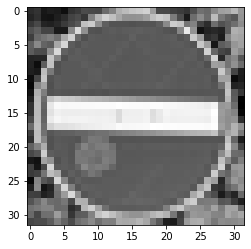

In [13]:
new_grays = np.mean(new_images, axis = -1)
new_grays = np.reshape(new_grays, [len(new_images), new_grays[0].shape[0], new_grays[0].shape[1], 1])
X_new = np.divide(np.subtract(new_grays, np.mean(new_grays)), np.mean(new_grays))

plt.imshow(X_new[index, :, :, 0], cmap='gray')

### Prediction Operation

In [14]:
prediction_operation = tf.nn.softmax(logits)

### Predict the Sign Type for Each Image

In [15]:
## Load Saved Model
saver = tf.train.Saver()

with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, './lenet')
    prediction = sess.run(prediction_operation, feed_dict={x: X_new, keep_prob: 1.0})
    new_accuracy = evaluate(X_new, y_new)

INFO:tensorflow:Restoring parameters from ./lenet


### Model Performance on New Images

The accuracy of the model on the new images is as follows.

In [20]:
print(new_accuracy)

0.8333333134651184


### Top 5 Softmax Probabilities

In [21]:
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(prediction), k=5))
print(top5)

TopKV2(values=array([[1.0000000e+00, 2.0526193e-14, 2.4291518e-16, 1.4536758e-16,
        1.2742560e-16],
       [9.9999976e-01, 2.0735625e-07, 2.7036421e-08, 9.8888266e-09,
        4.7915929e-09],
       [1.0000000e+00, 1.1330560e-18, 3.3650832e-20, 1.5862990e-21,
        4.8321656e-22],
       [9.9999559e-01, 4.3708465e-06, 2.4847937e-08, 2.1150043e-08,
        1.7308187e-08],
       [9.9971980e-01, 2.4624236e-04, 1.3201782e-05, 5.0615731e-06,
        4.2776933e-06],
       [6.8966967e-01, 1.2849243e-01, 1.2607929e-01, 3.2432131e-02,
        2.1688623e-02]], dtype=float32), indices=array([[38, 14, 13, 25, 15],
       [25, 20, 12, 31, 17],
       [17,  8, 14,  0,  3],
       [18, 26, 27, 11,  8],
       [28, 20, 29, 30, 11],
       [42, 20, 30, 25, 11]]))


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [22]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")